In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
import torch
from torch.utils.data import dataset
import argparse
import time
import os
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader


def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]


def get_all_column_names(predicates):
    column_names = set()
    for query in predicates:
        for predicate in query:
            if len(predicate) == 3:
                column_name = predicate[0]
                column_names.add(column_name)
    return column_names


def get_all_table_names(tables):
    table_names = set()
    for query in tables:
        for table in query:
            table_names.add(table)
    return table_names


def get_all_operators(predicates):
    operators = set()
    for query in predicates:
        for predicate in query:
            if len(predicate) == 3:
                operator = predicate[1]
                operators.add(operator)
    return operators


def get_all_joins(joins):
    join_set = set()
    for query in joins:
        for join in query:
            join_set.add(join)
    return join_set


def idx_to_onehot(idx, num_elements):
    onehot = np.zeros(num_elements, dtype=np.float32)
    onehot[idx] = 1.
    return onehot


def get_set_encoding(source_set, onehot=True):
    num_elements = len(source_set)
    source_list = list(source_set)
    # Sort list to avoid non-deterministic behavior
    source_list.sort()
    # Build map from s to i
    thing2idx = {s: i for i, s in enumerate(source_list)}
    # Build array (essentially a map from idx to s)
    idx2thing = [s for i, s in enumerate(source_list)]
    if onehot:
        thing2vec = {s: idx_to_onehot(i, num_elements) for i, s in enumerate(source_list)}
        return thing2vec, idx2thing
    return thing2idx, idx2thing


def get_min_max_vals(predicates, column_names):
    min_max_vals = {t: [float('inf'), float('-inf')] for t in column_names}
    for query in predicates:
        for predicate in query:
            if len(predicate) == 3:
                column_name = predicate[0]
                val = float(predicate[2])
                if val < min_max_vals[column_name][0]:
                    min_max_vals[column_name][0] = val
                if val > min_max_vals[column_name][1]:
                    min_max_vals[column_name][1] = val
    return min_max_vals


def normalize_data(val, column_name, column_min_max_vals):
    min_val = column_min_max_vals[column_name][0]
    max_val = column_min_max_vals[column_name][1]
    val = float(val)
    val_norm = 0.0
    if max_val > min_val:
        val_norm = (val - min_val) / (max_val - min_val)
    return np.array(val_norm, dtype=np.float32)


def normalize_labels(labels, min_val=None, max_val=None):
    labels = np.array([np.log(float(l)) for l in labels])
    if min_val is None:
        min_val = labels.min()
        print("min log(label): {}".format(min_val))
    if max_val is None:
        max_val = labels.max()
        print("max log(label): {}".format(max_val))
    labels_norm = (labels - min_val) / (max_val - min_val)
    # Threshold labels
    labels_norm = np.minimum(labels_norm, 1)
    labels_norm = np.maximum(labels_norm, 0)
    return labels_norm, min_val, max_val


def unnormalize_labels(labels_norm, min_val, max_val):
    labels_norm = np.array(labels_norm, dtype=np.float32)
    labels = (labels_norm * (max_val - min_val)) + min_val
    return np.array(np.round(np.exp(labels)), dtype=np.int64)


def encode_samples(tables, samples, table2vec):
    samples_enc = []
    for i, query in enumerate(tables):
        samples_enc.append(list())
        for j, table in enumerate(query):
            sample_vec = []
            # Append table one-hot vector
            sample_vec.append(table2vec[table])
            # Append bit vector
            sample_vec.append(samples[i][j])
            sample_vec = np.hstack(sample_vec)
            samples_enc[i].append(sample_vec)
    return samples_enc


def encode_data(predicates, joins, column_min_max_vals, column2vec, op2vec, join2vec):
    predicates_enc = []
    joins_enc = []
    for i, query in enumerate(predicates):
        predicates_enc.append(list())
        joins_enc.append(list())
        for predicate in query:
            if len(predicate) == 3:
                # Proper predicate
                column = predicate[0]
                operator = predicate[1]
                val = predicate[2]
                norm_val = normalize_data(val, column, column_min_max_vals)

                pred_vec = []
                pred_vec.append(column2vec[column])
                pred_vec.append(op2vec[operator])
                pred_vec.append(norm_val)
                pred_vec = np.hstack(pred_vec)
            else:
                pred_vec = np.zeros((len(column2vec) + len(op2vec) + 1))

            predicates_enc[i].append(pred_vec)

        for predicate in joins[i]:
            # Join instruction
            join_vec = join2vec[predicate]
            joins_enc[i].append(join_vec)
    return predicates_enc, joins_enc

#Modified model with CNN and residual connection
class ModifiedSetConv(nn.Module):
    def __init__(self, sample_feats, predicate_feats, join_feats, hid_units):
        super(ModifiedSetConv, self).__init__()
        self.dropout_rate = 0.2  # Adjustable dropout rate

        # Convolutional layers
        self.sample_conv1 = nn.Conv1d(in_channels=sample_feats, out_channels=hid_units, kernel_size=3, padding=1)
        self.sample_conv2 = nn.Conv1d(in_channels=hid_units, out_channels=hid_units, kernel_size=3, padding=1)

        self.predicate_conv1 = nn.Conv1d(in_channels=predicate_feats, out_channels=hid_units, kernel_size=3, padding=1)
        self.predicate_conv2 = nn.Conv1d(in_channels=hid_units, out_channels=hid_units, kernel_size=3, padding=1)

        self.join_conv1 = nn.Conv1d(in_channels=join_feats, out_channels=hid_units, kernel_size=3, padding=1)
        self.join_conv2 = nn.Conv1d(in_channels=hid_units, out_channels=hid_units, kernel_size=3, padding=1)

        # Residual connection
        self.sample_res = nn.Conv1d(in_channels=sample_feats, out_channels=hid_units, kernel_size=1)
        self.predicate_res = nn.Conv1d(in_channels=predicate_feats, out_channels=hid_units, kernel_size=1)
        self.join_res = nn.Conv1d(in_channels=join_feats, out_channels=hid_units, kernel_size=1)

        # Output layers
        self.fc1 = nn.Linear(hid_units * 3, hid_units)
        self.fc2 = nn.Linear(hid_units, 1)
        self.dropout = nn.Dropout(self.dropout_rate)

    def forward(self, samples, predicates, joins, sample_mask, predicate_mask, join_mask):
        # Reshape input to fit Conv1d (batch_size, channels, sequence_length)
        samples = samples.permute(0, 2, 1)
        predicates = predicates.permute(0, 2, 1)
        joins = joins.permute(0, 2, 1)

        # Sample path
        x_sample_res = self.sample_res(samples)
        x_sample = F.relu(self.sample_conv1(samples))
        x_sample = F.relu(self.sample_conv2(x_sample) + x_sample_res)  # Adding residual connection
        x_sample = torch.sum(x_sample, dim=2) / sample_mask.sum(1)  # Pooling and normalize

        # Predicate path
        x_predicate_res = self.predicate_res(predicates)
        x_predicate = F.relu(self.predicate_conv1(predicates))
        x_predicate = F.relu(self.predicate_conv2(x_predicate) + x_predicate_res)  # Adding residual connection
        x_predicate = torch.sum(x_predicate, dim=2) / predicate_mask.sum(1)  # Pooling and normalize

        # Join path
        x_join_res = self.join_res(joins)
        x_join = F.relu(self.join_conv1(joins))
        x_join = F.relu(self.join_conv2(x_join) + x_join_res)  # Adding residual connection
        x_join = torch.sum(x_join, dim=2) / join_mask.sum(1)  # Pooling and normalize

        # Combine and process final outputs
        x = torch.cat((x_sample, x_predicate, x_join), dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        out = torch.sigmoid(self.fc2(x))

        return out



#Modified model with CNN
# class SetConv_CNN(nn.Module):
#     def __init__(self, sample_feats, predicate_feats, join_feats, hid_units):
#         super(SetConv_CNN, self).__init__()
#         self.dropout_rate = 0.2  # Adjust dropout rate as needed

#         # Define convolutional layers for each path with kernel size, stride and padding appropriately selected
#         self.sample_conv1 = nn.Conv1d(in_channels=sample_feats, out_channels=hid_units, kernel_size=3, padding=1)
#         self.sample_conv2 = nn.Conv1d(in_channels=hid_units, out_channels=hid_units, kernel_size=3, padding=1)

#         self.predicate_conv1 = nn.Conv1d(in_channels=predicate_feats, out_channels=hid_units, kernel_size=3, padding=1)
#         self.predicate_conv2 = nn.Conv1d(in_channels=hid_units, out_channels=hid_units, kernel_size=3, padding=1)

#         self.join_conv1 = nn.Conv1d(in_channels=join_feats, out_channels=hid_units, kernel_size=3, padding=1)
#         self.join_conv2 = nn.Conv1d(in_channels=hid_units, out_channels=hid_units, kernel_size=3, padding=1)

#         # Define output layers
#         self.fc1 = nn.Linear(hid_units * 3, hid_units)  # Combine features from all three paths
#         self.fc2 = nn.Linear(hid_units, 1)
#         self.dropout = nn.Dropout(self.dropout_rate)

    # def forward(self, samples, predicates, joins, sample_mask, predicate_mask, join_mask):
    #     # Reshape input to fit Conv1d (batch_size, channels, sequence_length)
    #     samples = samples.permute(0, 2, 1)
    #     predicates = predicates.permute(0, 2, 1)
    #     joins = joins.permute(0, 2, 1)

    #     # Sample path
    #     x_sample = F.relu(self.sample_conv1(samples))
    #     x_sample = F.relu(self.sample_conv2(x_sample))
    #     x_sample = torch.sum(x_sample, dim=2) / sample_mask.sum(1)  # Pooling and normalize

    #     # Predicate path
    #     x_predicate = F.relu(self.predicate_conv1(predicates))
    #     x_predicate = F.relu(self.predicate_conv2(x_predicate))
    #     x_predicate = torch.sum(x_predicate, dim=2) / predicate_mask.sum(1)  # Pooling and normalize

    #     # Join path
    #     x_join = F.relu(self.join_conv1(joins))
    #     x_join = F.relu(self.join_conv2(x_join))
    #     x_join = torch.sum(x_join, dim=2) / join_mask.sum(1)  # Pooling and normalize

    #     # Combine and process final outputs
    #     x = torch.cat((x_sample, x_predicate, x_join), dim=1)
    #     x = F.relu(self.fc1(x))
    #     x = self.dropout(x)
    #     out = torch.sigmoid(self.fc2(x))

    #     return out


def load_data(file_name, num_materialized_samples):
    joins = []
    predicates = []
    tables = []
    samples = []
    label = []

    # Load queries
    with open(file_name + ".csv", 'rU') as f:
        data_raw = list(list(rec) for rec in csv.reader(f, delimiter='#'))
        for row in data_raw:
            tables.append(row[0].split(','))
            joins.append(row[1].split(','))
            predicates.append(row[2].split(','))
            if int(row[3]) < 1:
                print("Queries must have non-zero cardinalities")
                exit(1)
            label.append(row[3])
    print("Loaded queries")

    # Load bitmaps
    num_bytes_per_bitmap = int((num_materialized_samples + 7) >> 3)
    with open(file_name + ".bitmaps", 'rb') as f:
        for i in range(len(tables)):
            four_bytes = f.read(4)
            if not four_bytes:
                print("Error while reading 'four_bytes'")
                exit(1)
            num_bitmaps_curr_query = int.from_bytes(four_bytes, byteorder='little')
            bitmaps = np.empty((num_bitmaps_curr_query, num_bytes_per_bitmap * 8), dtype=np.uint8)
            for j in range(num_bitmaps_curr_query):
                # Read bitmap
                bitmap_bytes = f.read(num_bytes_per_bitmap)
                if not bitmap_bytes:
                    print("Error while reading 'bitmap_bytes'")
                    exit(1)
                bitmaps[j] = np.unpackbits(np.frombuffer(bitmap_bytes, dtype=np.uint8))
            samples.append(bitmaps)
    print("Loaded bitmaps")

    # Split predicates
    predicates = [list(chunks(d, 3)) for d in predicates]

    return joins, predicates, tables, samples, label



def load_and_encode_train_data(num_queries, num_materialized_samples):
    file_name_queries = "/content/data/train"
    file_name_column_min_max_vals = "/content/data/column_min_max_vals.csv"

    joins, predicates, tables, samples, label = load_data(file_name_queries, num_materialized_samples)

    # Get column name dict
    column_names = get_all_column_names(predicates)
    column2vec, idx2column = get_set_encoding(column_names)

    # Get table name dict
    table_names = get_all_table_names(tables)
    table2vec, idx2table = get_set_encoding(table_names)

    # Get operator name dict
    operators = get_all_operators(predicates)
    op2vec, idx2op = get_set_encoding(operators)

    # Get join name dict
    join_set = get_all_joins(joins)
    join2vec, idx2join = get_set_encoding(join_set)

    # Get min and max values for each column
    with open(file_name_column_min_max_vals, 'rU') as f:
        data_raw = list(list(rec) for rec in csv.reader(f, delimiter=','))
        column_min_max_vals = {}
        for i, row in enumerate(data_raw):
            if i == 0:
                continue
            column_min_max_vals[row[0]] = [float(row[1]), float(row[2])]

    # Get feature encoding and proper normalization
    samples_enc = encode_samples(tables, samples, table2vec)
    predicates_enc, joins_enc = encode_data(predicates, joins, column_min_max_vals, column2vec, op2vec, join2vec)
    label_norm, min_val, max_val = normalize_labels(label)

    # Split in training and validation samples
    num_train = int(num_queries * 0.9)
    num_test = num_queries - num_train

    samples_train = samples_enc[:num_train]
    predicates_train = predicates_enc[:num_train]
    joins_train = joins_enc[:num_train]
    labels_train = label_norm[:num_train]

    samples_test = samples_enc[num_train:num_train + num_test]
    predicates_test = predicates_enc[num_train:num_train + num_test]
    joins_test = joins_enc[num_train:num_train + num_test]
    labels_test = label_norm[num_train:num_train + num_test]

    print("Number of training samples: {}".format(len(labels_train)))
    print("Number of validation samples: {}".format(len(labels_test)))

    max_num_joins = max(max([len(j) for j in joins_train]), max([len(j) for j in joins_test]))
    max_num_predicates = max(max([len(p) for p in predicates_train]), max([len(p) for p in predicates_test]))

    dicts = [table2vec, column2vec, op2vec, join2vec]
    train_data = [samples_train, predicates_train, joins_train]
    test_data = [samples_test, predicates_test, joins_test]
    return dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data


def make_dataset(samples, predicates, joins, labels, max_num_joins, max_num_predicates):
    """Add zero-padding and wrap as tensor dataset."""

    sample_masks = []
    sample_tensors = []
    for sample in samples:
        sample_tensor = np.vstack(sample)
        num_pad = max_num_joins + 1 - sample_tensor.shape[0]
        sample_mask = np.ones_like(sample_tensor).mean(1, keepdims=True)
        sample_tensor = np.pad(sample_tensor, ((0, num_pad), (0, 0)), 'constant')
        sample_mask = np.pad(sample_mask, ((0, num_pad), (0, 0)), 'constant')
        sample_tensors.append(np.expand_dims(sample_tensor, 0))
        sample_masks.append(np.expand_dims(sample_mask, 0))
    sample_tensors = np.vstack(sample_tensors)
    sample_tensors = torch.FloatTensor(sample_tensors)
    sample_masks = np.vstack(sample_masks)
    sample_masks = torch.FloatTensor(sample_masks)

    predicate_masks = []
    predicate_tensors = []
    for predicate in predicates:
        predicate_tensor = np.vstack(predicate)
        num_pad = max_num_predicates - predicate_tensor.shape[0]
        predicate_mask = np.ones_like(predicate_tensor).mean(1, keepdims=True)
        predicate_tensor = np.pad(predicate_tensor, ((0, num_pad), (0, 0)), 'constant')
        predicate_mask = np.pad(predicate_mask, ((0, num_pad), (0, 0)), 'constant')
        predicate_tensors.append(np.expand_dims(predicate_tensor, 0))
        predicate_masks.append(np.expand_dims(predicate_mask, 0))
    predicate_tensors = np.vstack(predicate_tensors)
    predicate_tensors = torch.FloatTensor(predicate_tensors)
    predicate_masks = np.vstack(predicate_masks)
    predicate_masks = torch.FloatTensor(predicate_masks)

    join_masks = []
    join_tensors = []
    for join in joins:
        join_tensor = np.vstack(join)
        num_pad = max_num_joins - join_tensor.shape[0]
        join_mask = np.ones_like(join_tensor).mean(1, keepdims=True)
        join_tensor = np.pad(join_tensor, ((0, num_pad), (0, 0)), 'constant')
        join_mask = np.pad(join_mask, ((0, num_pad), (0, 0)), 'constant')
        join_tensors.append(np.expand_dims(join_tensor, 0))
        join_masks.append(np.expand_dims(join_mask, 0))
    join_tensors = np.vstack(join_tensors)
    join_tensors = torch.FloatTensor(join_tensors)
    join_masks = np.vstack(join_masks)
    join_masks = torch.FloatTensor(join_masks)

    target_tensor = torch.FloatTensor(labels)

    return dataset.TensorDataset(sample_tensors, predicate_tensors, join_tensors, target_tensor, sample_masks,
                                 predicate_masks, join_masks)


def get_train_datasets(num_queries, num_materialized_samples):
    dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data = load_and_encode_train_data(
        num_queries, num_materialized_samples)
    train_dataset = make_dataset(*train_data, labels=labels_train, max_num_joins=max_num_joins,
                                 max_num_predicates=max_num_predicates)
    print("Created TensorDataset for training data")
    test_dataset = make_dataset(*test_data, labels=labels_test, max_num_joins=max_num_joins,
                                max_num_predicates=max_num_predicates)
    print("Created TensorDataset for validation data")
    return dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_dataset, test_dataset



def unnormalize_torch(vals, min_val, max_val):
    vals = (vals * (max_val - min_val)) + min_val
    return torch.exp(vals)


def qerror_loss(preds, targets, min_val, max_val):
    qerror = []
    preds = unnormalize_torch(preds, min_val, max_val)
    targets = unnormalize_torch(targets, min_val, max_val)

    for i in range(len(targets)):
        if (preds[i] > targets[i]).cpu().data.numpy()[0]:
            qerror.append(preds[i] / targets[i])
        else:
            qerror.append(targets[i] / preds[i])
    return torch.mean(torch.cat(qerror))


def predict(model, data_loader, cuda):
    preds = []
    t_total = 0.
    model.eval()
    for batch_idx, data_batch in enumerate(data_loader):

        samples, predicates, joins, targets, sample_masks, predicate_masks, join_masks = data_batch

        if cuda:
            samples, predicates, joins, targets = samples.cuda(), predicates.cuda(), joins.cuda(), targets.cuda()
            sample_masks, predicate_masks, join_masks = sample_masks.cuda(), predicate_masks.cuda(), join_masks.cuda()
        samples, predicates, joins, targets = Variable(samples), Variable(predicates), Variable(joins), Variable(
            targets)
        sample_masks, predicate_masks, join_masks = Variable(sample_masks), Variable(predicate_masks), Variable(
            join_masks)

        t = time.time()
        outputs = model(samples, predicates, joins, sample_masks, predicate_masks, join_masks)
        t_total += time.time() - t

        for i in range(outputs.data.shape[0]):
            preds.append(outputs.data[i])

    return preds, t_total



def print_qerror(preds_unnorm, labels_unnorm):
    qerror = []
    # Ensure inputs are numpy arrays for consistent handling
    preds_unnorm = np.array(preds_unnorm, dtype=np.float32)
    labels_unnorm = np.array(labels_unnorm, dtype=np.float32)

    for i in range(len(preds_unnorm)):
        pred = preds_unnorm[i]
        label = labels_unnorm[i]
        # Ensure both pred and label are scalars for division
        if pred > label:
            qerror.append(pred / label)
        else:
            qerror.append(label / pred)

    qerror = np.array(qerror)  # Convert list to numpy array for statistical functions
    print("Median: {}".format(np.median(qerror)))
    print("90th percentile: {}".format(np.percentile(qerror, 90)))
    print("95th percentile: {}".format(np.percentile(qerror, 95)))
    print("99th percentile: {}".format(np.percentile(qerror, 99)))
    print("Max: {}".format(np.max(qerror)))
    print("Mean: {}".format(np.mean(qerror)))


def train_and_predict(workload_name, num_queries, num_epochs, batch_size, hid_units, cuda=False):
    # Load training and validation data
    num_materialized_samples = 1000
    dicts, column_min_max_vals, min_val, max_val, labels_train, labels_test, max_num_joins, max_num_predicates, train_data, test_data = get_train_datasets(
        num_queries, num_materialized_samples)

    # Train model
    sample_feats = len(dicts[0]) + num_materialized_samples
    predicate_feats = len(dicts[1]) + len(dicts[2]) + 1
    join_feats = len(dicts[3])

    model = ModifiedSetConv(sample_feats, predicate_feats, join_feats, hid_units)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Data loaders
    train_data_loader = DataLoader(train_data, batch_size=batch_size)
    test_data_loader = DataLoader(test_data, batch_size=batch_size)

    # Train model
    model.train()
    for epoch in range(num_epochs):
        loss_total = 0.

        for batch_idx, data_batch in enumerate(train_data_loader):
            samples, predicates, joins, targets, sample_masks, predicate_masks, join_masks = data_batch

            # Run model
            outputs = model(samples, predicates, joins, sample_masks, predicate_masks, join_masks)
            loss = qerror_loss(outputs, targets.float(), min_val, max_val)
            loss_total += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print("Epoch {}, loss: {}".format(epoch, loss_total / len(train_data_loader)))

    # Validation
    model.eval()
    with torch.no_grad():
        preds_test, _ = predict(model, test_data_loader, cuda)
        preds_test_unnorm = unnormalize_labels(preds_test, min_val, max_val)
        labels_test_unnorm = unnormalize_labels(labels_test, min_val, max_val)

        print("\nQ-Error validation set:")
        print_qerror(preds_test_unnorm, labels_test_unnorm)

def main(testset='synthetic', queries=10000, epochs=10, batch=1024, hid=256):
    train_and_predict(testset, queries, epochs, batch, hid, cuda=False)

# Example call
main(testset='scale', queries=6000, epochs=150, batch=400, hid=128)


FileNotFoundError: [Errno 2] No such file or directory: '/content/data/train.csv'

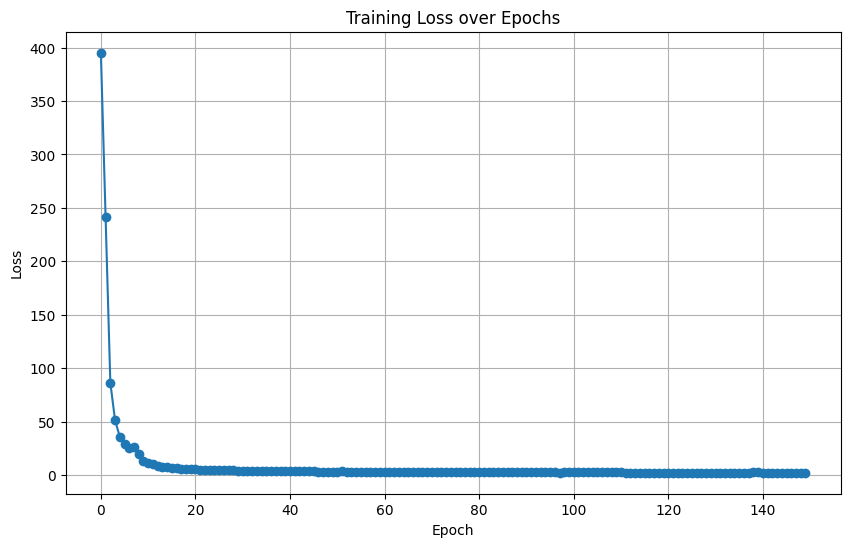

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(150))  # Assuming 150 epochs
loss_values = [
    395.1378261021205, 241.07403346470423, 86.52479090009417, 51.32700783865793, 36.026547704424175,
    29.127995491027832, 25.21650423322405, 26.037455013820104, 20.065981115613663, 13.363799231392997,
    11.164984396525792, 10.197362491062709, 8.959369148526873, 8.111882039478846, 7.3583952358790805,
    6.742632559367588, 6.634049892425537, 6.143478325435093, 5.807376555034092, 5.844632625579834,
    5.591985532215664, 5.314040047781808, 5.006323678152902, 4.983042461531503, 4.797314030783517,
    4.790436404091971, 4.66345865385873, 4.589493479047503, 4.615839770862034, 4.376040152141026,
    4.392090371676853, 4.267454079219273, 4.071239760943821, 4.083013789994376, 4.023034266063145,
    3.893342205456325, 3.961550303867885, 3.8238401242664883, 3.8260814802987233, 3.768895983695984,
    3.6374368837901523, 3.667690736906869, 3.5331750086375644, 3.5213640247072493, 3.532508747918265,
    3.529361571584429, 3.4696840729032243, 3.4282524585723877, 3.392194083758763, 3.450771995953151,
    3.315987161227635, 3.582858715738569, 3.472845230783735, 3.341963768005371, 3.2398096663611278,
    3.1947281701224193, 3.262454526765006, 3.201199327196394, 3.163353749683925, 3.1110603979655673,
    3.113699878965105, 3.089980517114912, 2.9907722813742503, 3.081830246107919, 2.9563471930367604,
    2.9997369050979614, 3.0037802968706404, 3.0078927108219693, 3.086635947227478, 2.958267160824367,
    2.932515467916216, 2.9392327070236206, 2.8950248786381314, 2.80914763041905, 2.939070531300136,
    2.8827366828918457, 2.906066690172468, 2.78228611605508, 2.7861547470092773, 2.798818366868155,
    2.7751307487487793, 2.747038551739284, 2.7546065534864153, 2.7774675403322493, 2.77508544921875,
    2.773702996117728, 2.7331090484346663, 2.8323803458895003, 2.7189941235951016, 2.7103371790477206,
    2.7096786499023438, 2.677763206618173, 2.6101122753960744, 2.6476376397269115, 2.6617040123258318,
    2.575154049055917, 2.6234340838023593, 2.530229023524693, 2.687024814741952, 2.581781966345651,
    2.6392320905412947, 2.64791282585689, 2.7034865617752075, 2.574937547956194, 2.585672233785902,
    2.6209466797964915, 2.646137765475682, 2.5753627845219205, 2.725035343851362, 2.6867771659578596,
    2.567517246518816, 2.4998758350099837, 2.4633253812789917, 2.5374621834073747, 2.4711793831416538,
    2.478224890572684, 2.46951230934688, 2.458404907158443, 2.4824340513774326, 2.473321693284171,
    2.398397045476096, 2.46338905606951, 2.4625627994537354, 2.390879137175424, 2.4836734192711964,
    2.5056286369051253, 2.5320194278444563, 2.4751067672457014, 2.4593448809215, 2.4281612804957797,
    2.469981244632176, 2.3584043043000356, 2.4079691086496626, 2.4393217393330167, 2.462585849421365,
    2.477842228753226, 2.5042186890329634, 2.5271664432116916, 2.619382245200021, 2.637970498629979,
    2.5448556457247054, 2.4718018770217896, 2.4763576643807546, 2.434452874319894, 2.3880372047424316,
    2.3996316705431258, 2.416580183165414, 2.352173089981079, 2.370722327913557, 2.3763825382505144
]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
